In [111]:
#This notebook is from https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
plt.figure(facecolor='white')

In [61]:
#1. 데이터 불러오고 전처리하기
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


#sns.set은 세팅하는것인듯.
sns.set(style='white', context='notebook', palette='deep')

train_gen = ImageDataGenerator(1. / 783)


In [62]:
train = pd.read_csv('data/all/train.csv') #pandas dataframe의 형태로 불러옴.
test = pd.read_csv('data/all/test.csv')

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

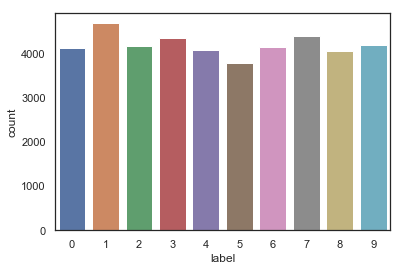

In [63]:
Y_train = train["label"]

#Label 칼람 드랍하기
X_train = train.drop(labels = ["label"], axis = 1)

del train

#각 클래스마다 같은 비슷한 개수의 데이터를 가지고 있는지 체크하기.

#간단하게 그래프를 그려주는 seaborn.countplot
g = sns.countplot(Y_train)

Y_train.value_counts()

In [64]:
#null 또는 없는 값이 있는지 찾기

X_train.isnull().any().describe()
test.isnull().any().describe()
#missing 값이 없는 것을 확인함.(있으면 어떻게 나오는데?)

count       784
unique        1
top       False
freq        784
dtype: object

count       784
unique        1
top       False
freq        784
dtype: object

In [66]:
### 2.3 data normalization ###

#만약 255로 안 나누면 어떤 일이 벌어질까? 왜 0 부터 1 이어야 하지? 어차피 값들은 다 유사한데.
X_train = X_train / 255.0
test = test / 255.0

### 2.3 Reshape

#reshape에서 첫 번째 것을 -1로 놓은 이유는 아마 그대로 이기 때문인듯?
#reshape를 하는 이유는 CNN을 하기 위해서인듯.
X_train = X_train.values.reshape(-1, 28, 28,1) #높이, 넓이 각 28, canal = 1?
test = test.values.reshape(-1, 28, 28, 1)


### 2.5 Label encoding
Y_train = to_categorical(Y_train, num_classes=10)





In [67]:
X_train.shape # 4번째 차원은 Channel로 여기선 색이 하나이므로 1.

(42000, 28, 28, 1)

In [68]:
X_val = X_train[:10000]

In [69]:
# 주의 : 데이터를 split할때는 클래스별로 고르게 split되도록 해라.
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.1, random_state=random_seed)
## random_state를 주었으니 랜덤하게 추출될 것이다.

In [70]:
X_train.shape

(37800, 28, 28, 1)

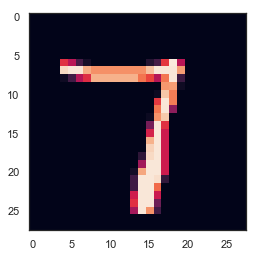

In [71]:
g = plt.imshow(X_train[1][:,:,0])

In [72]:
### 3. CNN
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
### 3.1 모델 정의하기

### (1) 첫번째는 Convolutional Layer(Conv2D)
###   첫 두개에는 32개필터를 넣을것이고, 마지막 2개에는 64필터를 넣을것이다.
###   각 필터는 각 부분의 이미지를 필터링한다 (커널 사이즈에 따라.)
###   커널 필터 매트릭스는 전체 이미지에 적용된다... 그리고 이미지를 변형시킨다.
###   CNN은 필터로 인해 변형된 이미지의 특징을 고립시킬 수 있다.
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same',
    activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(
    filters = 32, kernel_size = (5,5), padding = 'Same',
    activation = 'relu'))
        
### (2) Max Pooling
###   두 번째로 중요한 레이어는 맥스 풀링 2D레이어이다. 이 레이어는 단순하게 '다운셈플링'
###   역할을 한다. 인접한 두 픽셀 중 가장 큰 것을 고른다.
###   오버피팅과 계산량을 줄이기 위해 사용된다.
###   풀링 사이즈도 역시 중요한데, 풀링 사이즈가 클수록 다운샘플링이 더 중요해진다.
###   
###   두 레이어를 함께 씀으로써 로컬 피쳐와 글로벌 피쳐를 둘 다 익힐 수 있다.
model.add(MaxPooling2D(pool_size=(2,2)))

### (3) 드랍아웃
###   드랍아웃은 'regularzation' 메소드이다.
###   레이어에서 일정 비율의 노드들이 고의적으로 무시된다. (weight가 0으로 설정)
###   이 테크닉은 오버피팅을 역시 감소시키고 generalization을 증가시킨다.

model.add(Dropout(0.25)) #why 0.25?

model.add(Conv2D(
    filters = 64, kernel_size = (3,3), padding = 'Same',
    activation = 'relu', input_shape = (28,28,1)
))
model.add(Conv2D(
    filters = 64, kernel_size = (3,3), padding = 'Same',
    activation = 'relu', input_shape = (28,28,1)
))
          
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) #why 0.25?

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))




### (4)'relu'는 retifier (activation function)이다. 이것은 네트워크에 
###   non-linearity를 도입하기 위해 사용된다.

### (5) Flatten layer는 마지막 피처 맵을 1차원 백터로 변환시키기 위해 사용된다.


###   두 개의 Dense layer(Fully-connected layer)를 통해 artificial
###   neural network 분류기를 도입했다. 마지막 레이어에서는 softmax레이어를 썼다.
###   이 레이어는 각 클래스에 속할 확률을 의미한다.

In [118]:
### 3.2 옵티마이저와 annealer 정하기


### 옵티마이저들은 어떤 차이가 있을까 RMSProp, sgd, adam
optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])


### ** LR Anealing
### LR을 스텝에 따라 변경시킴으로써 글로벌 미니마에 더 가깝게 해주는 효과.

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 3 #epoch는 어떤 효과가 있나?
batch_size = 30


In [ ]:
### 3.3 Data augmentation(데이터 증대?증가?)
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)





# Fit the model
history = model.fit_generator(
    datagen.flow(X_train,Y_train, batch_size=batch_size),
    epochs = epochs, validation_data = (X_val,Y_val),
    verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
    , callbacks=[learning_rate_reduction])




Epoch 1/3
 - 316s - loss: 0.2689 - acc: 0.9179 - val_loss: 0.0975 - val_acc: 0.9707
Epoch 2/3


In [ ]:
############ 4. 모델 평가하기 #######################

#####4.1 Training and validation curves
#### loss와 accuracy 커브를 표현해보자.

fig, ax = plt.subplots(2,1) #그래프를 두개 세로로 만든다는 얘기.
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation loss', axes=ax[0])

legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


In [ ]:
#### 4.2 Confusion Matrix ###

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    이 함수는 Confusion matrix를 프린트합니다.
    normalize=True를 적용하면 normalize역시 가능합니다.
    """
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2
#     for i , j in itertools.product
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [ ]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis=1)

In [ ]:
Y_true = np.argmax(Y_val, axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

In [ ]:
plot_confusion_matrix(confiusion_mtx, classes=range(10))

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)